In [1]:
from __future__ import print_function
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


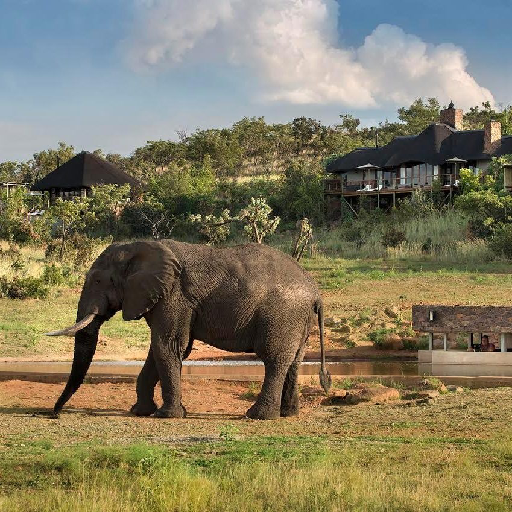

In [3]:
height = 512
width = 512

content_image_path = 'images/elephant.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

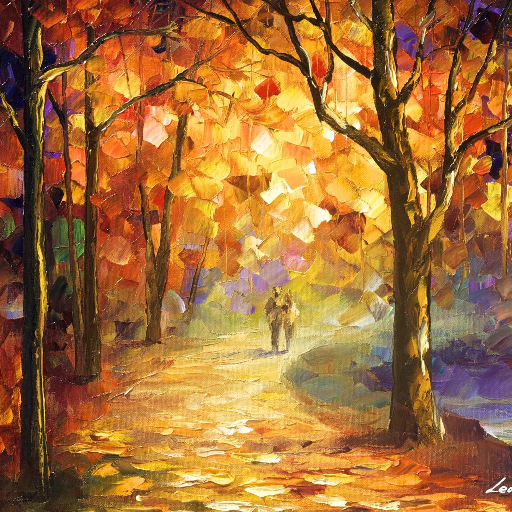

In [6]:
style_image_path1 = 'images/styles/forest.jpg'
style_image1 = Image.open(style_image_path1)
style_image1 = style_image1.resize((height, width))
style_image1

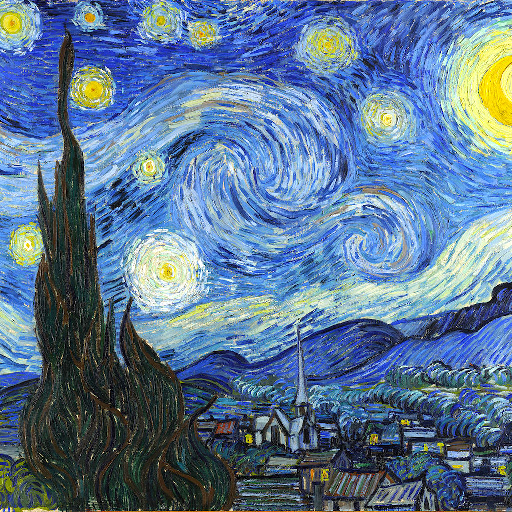

In [5]:
style_image_path2 = 'images/styles/starry_night.jpg'
style_image2 = Image.open(style_image_path2)
style_image2 = style_image2.resize((height, width))
style_image2

In [8]:
content_array = np.asarray(content_image, dtype='float32')[np.newaxis,:,:,:]
style_array1 = np.asarray(style_image1, dtype='float32')[np.newaxis,:,:,:]
style_array2 = np.asarray(style_image2, dtype='float32')[np.newaxis,:,:,:]

In [9]:
# preprocessing the data for VGG
# Subtract the mean RGB value 
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

style_array1[:, :, :, 0] -= 103.939
style_array1[:, :, :, 1] -= 116.779
style_array1[:, :, :, 2] -= 123.68

style_array2[:, :, :, 0] -= 103.939
style_array2[:, :, :, 1] -= 116.779
style_array2[:, :, :, 2] -= 123.68

# Flip the ordering of the multi-dimensional array from RGB to BGR
content_array = content_array[:, :, :, ::-1]
style_array1 = style_array1[:, :, :, ::-1]
style_array2 = style_array2[:, :, :, ::-1]

In [10]:
# define variables in keras beckend
content_image = backend.variable(content_array)
style_image1 = backend.variable(style_array1)
style_image2 = backend.variable(style_array2)
combination_image = backend.placeholder((1, height, width, 3))

In [11]:
input_tensor = backend.concatenate([content_image,
                                    style_image1,
                                    style_image2,
                                    combination_image],
                                    axis = 0)

In [12]:
# reuse a model pre-trained ofr image classification to
# define loss functions
model = VGG16(input_tensor=input_tensor, include_top=False)

In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(4, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(4, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(4, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(4, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(4, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(4, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(4, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(4, 64, 64, 512) dtype=float32>,
 'b

In [14]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [15]:
loss = backend.variable(0.)

In [17]:
# compute content_loss
def content_loss(content, combination):
    return backend.sum(backend.square(content - combination))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[3, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [21]:
# compute style_loss
# define gram_matrix
def gram_matrix(x):
    x = backend.batch_flatten(backend.permute_dimensions(x, (2,0,1)))
    return backend.dot(x, backend.transpose(x))

# define style_loss
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for feature_layer in feature_layers:
    layer_features = layers[feature_layer]
    style_features1 = layer_features[1, :, :, :]
    style_features2 = layer_features[2, :, :, :]
    combination_features = layer_features[3, :, :, :]
    loss += 0.5*(style_weight / len(feature_layers)) * style_loss(style_features1, combination_features)
    loss += 0.5*(style_weight / len(feature_layers)) * style_loss(style_features2, combination_features)

In [22]:
# total_variation_loss 
# encourage spatial smoothness
def total_variation_loss(x):
    a = backend.square(x[:, :height - 1, :width-1,:] - x[:, 1:,:width-1,:])
    b = backend.square(x[:, :height - 1, :width-1,:] - x[:, :height-1, 1:,:])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight*total_variation_loss(combination_image)

In [23]:
# Define needed gradients and solve the optimisation problem
grads = backend.gradients(loss, combination_image)

In [24]:
# Define Evaluator class that computes loss and gradients in one pass 
# while retrieving them via two separate functions, loss and grads.
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)